In [109]:
import pprint
import sys
import numpy as np

import matplotlib.pyplot as plt
import random 
import math
import pandas as pd
eps = np.finfo(float).eps
from numpy import log2 as log

In [110]:
a=pd.read_csv('train_data.csv')
a.describe()

df = pd.DataFrame(a)

In [111]:
# train, validate = np.split(df, [int(.8*len(df))]) #for sequential data
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))]) # for random 

In [112]:
def find_entropy(df):
    Class = 'left'   
    entropy = 0
    values = df['left'].unique()
    for value in values:
        fraction = df['left'].value_counts()[value]/float(len(df[Class]))
        entropy += -fraction*np.log2(fraction+eps)
    return entropy


In [113]:

def find_entropy_attribute(df,attribute):
    Class = 'left'   
    target_variables = df[Class].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    if len(target_variables) == 1 or len(variables) == 1:
        return 0;
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[Class] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*np.log2(fraction+eps)
        fraction2 = den/float(len(df))
        entropy2 += fraction2*entropy
    return entropy2


In [114]:

def min_num_entropy(df,attribute):
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    entropy2 = 0
    entropy1 = 0
    min_entr=sys.maxint
    min_split=sys.maxint
    entropy_fin=0
    for variable in variables:
        entropy = 0
        df1 = df[df[attribute]<=variable]
        df2 = df[df[attribute]>variable]
        entropy1 = find_entropy(df1)
        entropy2 = find_entropy(df2)

        
        fraction2 = len(df2)/float(len(df))
        fraction1 = len(df1)/float(len(df))
        entropy_fin = fraction1*entropy1+ fraction2*entropy2
        
        if min_entr>entropy_fin:
            min_entr=entropy_fin
            min_split=variable

    return min_entr,min_split


In [115]:
numerical_attributes=[]
for i in df.keys()[0:5]:
    numerical_attributes.append(i)
#     print(i)
# print numerical_attributes

In [116]:
def max_IG(dataf):    
    IG = []
    i=0
    split=-1
    max_=0
    max_in=None
    #categorical
    for key in dataf.keys()[5:-1]:
        if key!= 'left':
            temp_en = find_entropy_attribute(dataf,key) 
#             print temp_en
            ig1= find_entropy(dataf)-temp_en      
#             print("IG 1: ",ig1,key)        
            if ig1>max_:
                max_=ig1
                max_in=key
            IG.append(ig1)

    #continuous
    for key in dataf.keys()[0:5]:
        temp_en = min_num_entropy(dataf,key)[0]
        ig1=find_entropy(dataf)-temp_en    
#         print("IG 2conti: ",ig1,key)        
        if ig1>max_:
            max_=ig1
            max_in=key
            split=min_num_entropy(dataf,key)[1]      

        IG.append(ig1)
#     print 'ig=',IG
    return max_in,max_,split,IG

# max_IG(df)


In [117]:
class DTree:
    def __init__(self,pos=0,neg=0, child={},val = None,spl_pt=-1):
        self.val = val
        self.child = child
        self.pos=pos
        self.neg=neg
        self.spl_pt=spl_pt
        

def buildTree(df1,label_node,tree=None):
    max_ig_node,gn,split,Info_gain_array = max_IG(df1)
#     print max_ig_node,gn,split

    c_pos=0 #no. of positives for target attribute for this node(max ig node)
    c_len=0
    
    if gn <= 0.000001 or len(df1.columns)==1:
#         print 'IG-array',Info_gain_array
           ########switched 0 and 1
        c_pos=len(df1[df1[label_node]==1])
        c_len=len(df1[df1[label_node]==0])
        if c_pos>c_len:
            max_ig_node="YES"
        else:
            max_ig_node="NO"
        child={}
#         print "leaf nnode hai"
        leaf_n=DTree(c_pos,c_len,child,max_ig_node)
        return leaf_n

    print 'node is--- ',max_ig_node
    c_pos=len(df1[max_ig_node][df1[label_node]==1])
    c_len=len(df1[max_ig_node][df1[label_node]==0])
    child={}
    
    
    
    if split==-1:
        newnode=DTree(c_pos,c_len,child,max_ig_node,-1)
        attr = df1[max_ig_node].unique()
      
        for labels in attr:
            nd1=df1[df1[max_ig_node]==labels]
            nd1=nd1.drop(columns=[max_ig_node])
            newnode.spl_pt=-1
            newnode.child[labels] = buildTree(nd1,label_node) #Calling the function recursively 

    else:
        newnode=DTree(c_pos,c_len,child,max_ig_node,split)
        label1="<="+str(split)
        label2=">"+str(split)   

        nd1=df1[df1[max_ig_node]<=split]
        nd2=df1[df1[max_ig_node]>split]
#         print len(nd1)
#         print len(nd2)
        if len(nd1)==0 or len(nd2)==0:
            c_pos=len(df1[df1[label_node]==1])
            c_len=len(df1[df1[label_node]==0])
            if c_pos>c_len:
                max_ig_node="YES"
            else:
                max_ig_node="NO"
            child={}

            leaf_n=DTree(c_pos,c_len,child,max_ig_node)
            return leaf_n

        
        newnode.child[label1] = buildTree(nd1,label_node) #Calling the function recursively 
        newnode.child[label2] = buildTree(nd2,label_node) #Calling the function recursively 
    return newnode



In [118]:
def traverse(tree):
    print(tree.val) #,'split=',tree.spl_pt)
    if tree.val==1:
        return
    for k,vals in tree.child.items():
        pprint.pprint(k)
        traverse(vals)
    
tree = buildTree(train,'left')
pprint.pprint("tree")

traverse(tree)

node is---  satisfaction_level
node is---  number_project
node is---  average_montly_hours
node is---  average_montly_hours
node is---  last_evaluation
node is---  last_evaluation
node is---  satisfaction_level
node is---  satisfaction_level
node is---  salary
node is---  average_montly_hours
node is---  average_montly_hours
node is---  promotion_last_5years
node is---  satisfaction_level
node is---  satisfaction_level
node is---  sales
node is---  promotion_last_5years
node is---  sales
node is---  satisfaction_level
node is---  promotion_last_5years
node is---  sales
node is---  average_montly_hours
node is---  salary
node is---  average_montly_hours
node is---  satisfaction_level
node is---  satisfaction_level
node is---  satisfaction_level
node is---  number_project
node is---  average_montly_hours
node is---  sales
node is---  promotion_last_5years
node is---  average_montly_hours
node is---  average_montly_hours
node is---  average_montly_hours
node is---  Work_accident
node is--

In [119]:
def predict(row,tree,parent,uip):
    if tree.pos+tree.neg < uip:
        if parent.pos>parent.neg:
            return "YES"
        else:
            return "NO"
        
    if tree.val=="YES" or tree.val=="NO":
        return tree.val
    
    attr=row[tree.val]
    
    if tree.val in numerical_attributes:
        if attr<=tree.spl_pt:
            x="<="+str(tree.spl_pt)
            return predict(row,tree.child[x],tree,uip)
        else:
            x=">"+str(tree.spl_pt)
            return predict(row,tree.child[x],tree,uip)
    else:
        if attr in tree.child:
            return predict(row,tree.child[attr],tree,uip)
    return "NO"

def calc_meas(df,tree,uip):
    tp=0
    tn=0
    fp=0
    fn=0
    i=0
    while i< len(df):
        pred_val=predict(df.iloc[i],tree,None,uip)
        if df.iloc[i]['left']==1:
            if pred_val=="YES":
                tp=tp+1
            else:
                fn=fn+1 #### fn here 
        elif df.iloc[i]['left']==0:
            if pred_val=="NO":
                tn=tn+1
            else:
                fp=fp+1 #### fp here
        i=i+1
#         print"i="
    return tp,fp,tn,fn

        
# row=df.iloc[8]
# print (row)
i=500
nodes_v=[]
validate_errors=[]
while i<len(validate):    
    nodes_v.append(i)
#     print '\nno. of nodes',i
    tp,fp,tn,fn=calc_meas(validate,tree,i)
#     print 'Q5:-'
#     print "True Positive=",tp
#     print "True Negative=",tn
#     print "False positive=",fp
#     print "False negative=",fn
    err=(fp+fn)/float(total)
#     print "ERROR: ",err
    validate_errors.append(err)
    i=i+500

# print 'Validate erors ka array-',validate_errors


In [120]:
i=500
nodes_t=[]
train_errors=[]
while i<len(train):    
#     print '\nno. of nodes',i
    nodes_t.append(i)
    tp,fp,tn,fn=calc_meas(train,tree,i)
#     print 'Q5:-'
#     print "True Positive=",tp
#     print "True Negative=",tn
#     print "False positive=",fp
#     print "False negative=",fn
    err=(fp+fn)/float(total)
#     print "ERROR: ",err
    train_errors.append(err)
    i=i+500

# print 'train erors ka array-',train_errors


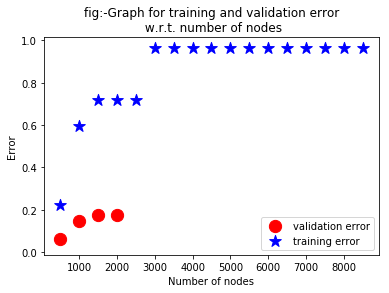

In [121]:
plt.scatter(nodes_v,validate_errors, label='validation error', color='red',s=150,  marker="o")
plt.scatter(nodes_t,train_errors, label='training error', color='blue',s=150, marker="*")
plt.xlabel('Number of nodes')
plt.ylabel('Error')
plt.title('fig:-Graph for training and validation error\n w.r.t. number of nodes')
plt.legend()

plt.savefig('q_5.png')
plt.show()